# Mejorar el rendimiento del modelo ML

$ conda install scikit-learn==1.5.2
$ conda install jupyter_black imbalanced-learn lightgbm catboost xgboost

In [4]:
%load_ext jupyter_black
# Importar bibliotecas
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import time
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    roc_auc_score,
    roc_curve,
    precision_score,
    recall_score,
    mean_squared_error,
)

# extrtree
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV


from sklearn.ensemble import BaggingClassifier
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.metrics import classification_report

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


In [5]:
df = pd.read_csv("./datasets/train_house_price.csv")

In [6]:
# variables categóricas
# 1. price_class: 1 si el precio es mayor que la mediana, 0 en otro caso

df.loc[df["last_price"] > df["last_price"].median(), "price_class"] = 1
df.loc[df["last_price"] <= df["last_price"].median(), "price_class"] = 0
print(df.head())

   last_price  total_area  bedrooms  ceiling_height  floors_total  \
0    108000.0        59.0         2            2.87             4   
1    264000.0       109.0         4            3.15             5   
2    140000.0        74.5         3            2.58            10   
3     64000.0        37.4         1            2.50             9   
4    133000.0        64.9         3            2.65            12   

   living_area  floor  bike_parking  studio  open_plan  kitchen_area  balcony  \
0         31.5      2             0       0          0           6.6        0   
1         72.0      2             0       0          0          12.2        0   
2         49.0      9             0       0          0          10.8        0   
3         20.0      4             0       0          0           6.2        2   
4         41.9     11             0       0          0          10.4        0   

   airports_nearest  cityCenters_nearest  price_class  
0             20485                 8180  

In [7]:
X = df.drop(["last_price", "price_class"], axis=1)
y = df["price_class"]

## Selección de variables

In [8]:
def feature_rf(X, y, n_estimators=50, outfile=None):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Entrenar el modelo ExtraTreesRegressor
    model = ExtraTreesRegressor(n_estimators=n_estimators, random_state=42)
    model.fit(X_train, y_train)

    # Obtener las importancias de las características
    importances = model.feature_importances_

    # Crear un DataFrame con las características y sus importancias
    feature_importances = pd.DataFrame(
        {"Feature": X.columns, "Importance": importances}
    )

    # Ordenar las características por importancia
    feature_importances = feature_importances.sort_values(
        by="Importance", ascending=False
    )

    # Mostrar las características más importantes
    print(feature_importances)

    # Graficar las importancias de las características
    plt.figure(figsize=(12, 8))
    plt.barh(
        feature_importances["Feature"],
        feature_importances["Importance"],
        color="skyblue",
    )
    plt.xlabel("Importancia")
    plt.ylabel("Característica")
    plt.title("Importancia de las Características con ExtraTreesRegressor")
    plt.gca().invert_yaxis()
    plt.show()

    # Evaluar el modelo utilizando diferentes números de características
    results = []
    for i in range(1, len(feature_importances) + 1):
        selected_features = feature_importances["Feature"][:i]
        X_train_selected = X_train[selected_features]
        X_test_selected = X_test[selected_features]

        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_test_selected)
        mse = mean_squared_error(y_test, y_pred)
        results.append((i, mse))

    # Convertir los resultados a un DataFrame
    results_df = pd.DataFrame(results, columns=["Number of Features", "MSE"])

    # Encontrar el número óptimo de características
    optimal_features = results_df.loc[results_df["MSE"].idxmin(), "Number of Features"]
    print(f"Número óptimo de características: {optimal_features}")

    # Graficar el ECM en función del número de características
    plt.figure(figsize=(10, 6))
    plt.plot(
        results_df["Number of Features"], results_df["MSE"], marker="o", linestyle="--"
    )
    plt.xlabel("Número de Características")
    plt.ylabel("ECM")
    plt.title("ECM en función del Número de Características")
    plt.axvline(optimal_features, color="r", linestyle="--")
    plt.show()

    # Guardar las características seleccionadas en un archivo CSV
    selected_features = feature_importances["Feature"][:optimal_features]
    selected_features_df = X[selected_features].copy()
    selected_features_df.loc[:, "price_class"] = y
    if outfile:
        selected_features_df.to_csv(outfile, index=False)

    return feature_importances, results_df, optimal_features

                Feature  Importance
0            total_area    0.263566
4           living_area    0.159045
9          kitchen_area    0.130435
12  cityCenters_nearest    0.126226
1              bedrooms    0.109596
3          floors_total    0.057690
2        ceiling_height    0.048080
11     airports_nearest    0.043650
5                 floor    0.038243
10              balcony    0.023218
6          bike_parking    0.000252
7                studio    0.000000
8             open_plan    0.000000


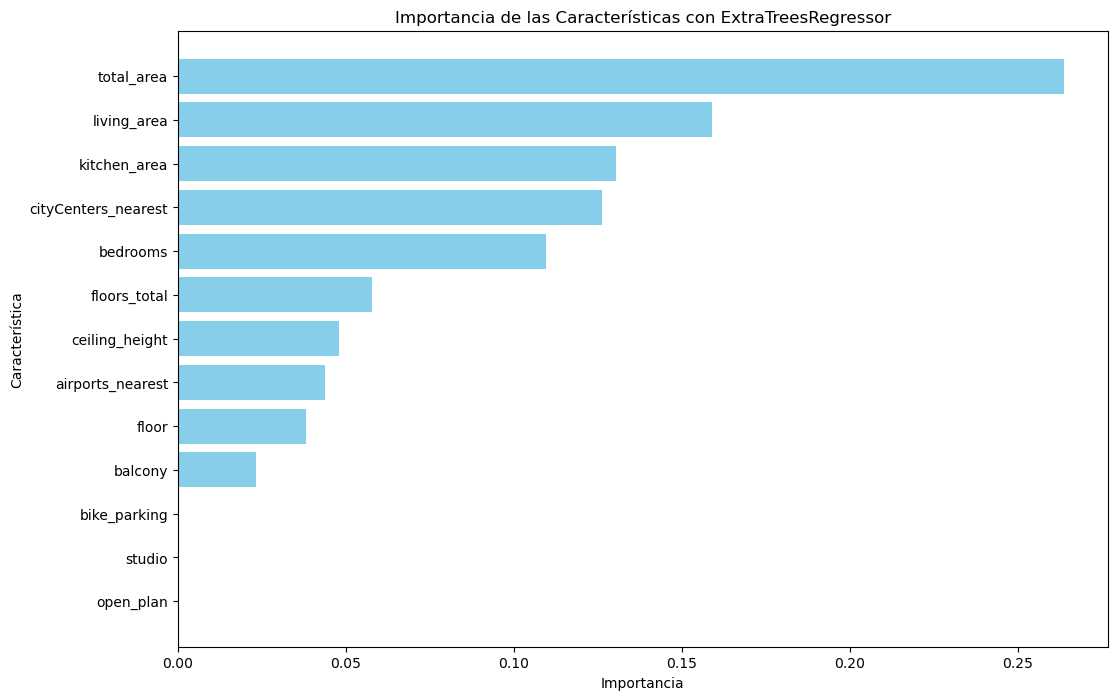

Número óptimo de características: 10


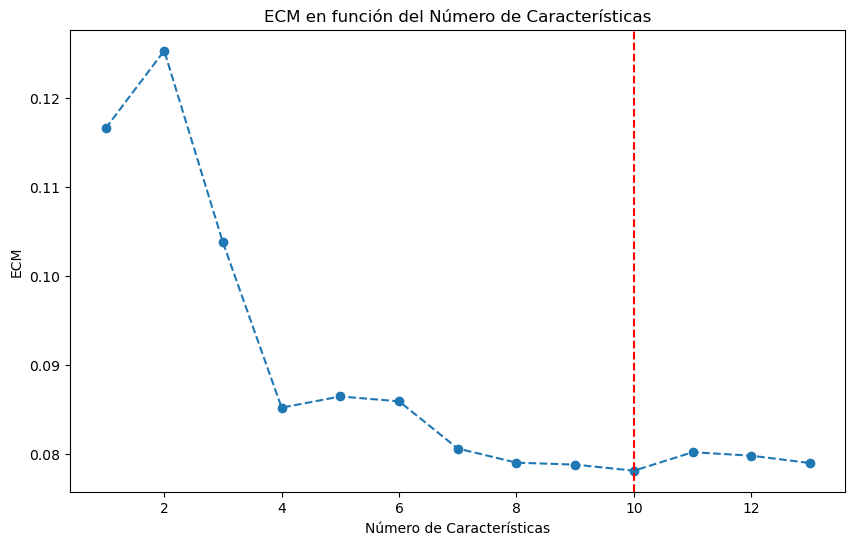

In [9]:
feature_importances, results_df, optimal_features = feature_rf(
    X, y, n_estimators=50, outfile="./datasets/data_filtered.csv"
)

<div class="alert alert-block alert-info">
<b>

### Selección de las 10 características mas importantes y guardarlas en un archivo csv

</b> <a class="tocSkip"></a>

In [10]:
data = pd.read_csv("./datasets/data_filtered.csv")
data.head()

,total_area,living_area,kitchen_area,cityCenters_nearest,bedrooms,floors_total,ceiling_height,airports_nearest,floor,balcony,price_class
0,59.0,31.5,6.6,8180,2,4,2.87,20485,2,0,0.0
1,109.0,72.0,12.2,8643,4,5,3.15,42683,2,0,1.0
2,74.5,49.0,10.8,16670,3,10,2.58,14078,9,0,1.0
3,37.4,20.0,6.2,17699,1,9,2.50,17792,4,2,0.0
4,64.9,41.9,10.4,10573,3,12,2.65,14767,11,0,1.0


## Balanceo de características

In [11]:
def plot_countplots(data, columns, title_prefix="", rotation=45):
    """
    Graficar conteos de valores en columnas categóricas

    data: DataFrame
    columns: Lista de columnas a graficar
    title_prefix: Prefijo para el título de la gráfica
    rotation: Rotación de las etiquetas del eje x
    """
    num_cols = len(columns)
    fig, axes = plt.subplots(num_cols, 1, figsize=(12, 4 * num_cols))
    if num_cols == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for i, column in enumerate(columns):
        if i < len(axes):
            sns.countplot(ax=axes[i], x=column, data=data)
            axes[i].set_title(f"{title_prefix} - {column}")
            axes[i].tick_params(axis="x", rotation=rotation)
        else:
            print(f"Column '{column}' not found in the DataFrame")
    plt.tight_layout()
    plt.show()

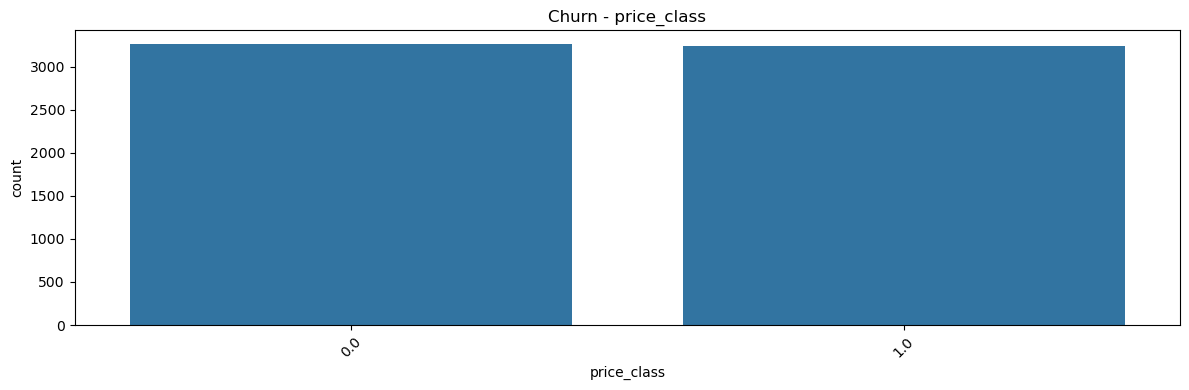

price_class
0.0    0.501617
1.0    0.498383
Name: proportion, dtype: float64


In [12]:
plot_countplots(data, ["price_class"], "Churn")
class_distribution = data["price_class"].value_counts(normalize=True)
print(class_distribution)

<div class="alert alert-block alert-info">
<b>

### Muestra balanceada, no es necesario balancearla con SMOTE

</b> <a class="tocSkip"></a>

## Escalamiento de características

In [13]:
def scale_data(data, target_column):
    """
    Escalar las características de un DataFrame

    data: DataFrame
    target_column: Nombre de la variable objetivo

    1. Separar características y variable objetivo
    2. Escalar las características
    3. Crear un nuevo DataFrame con las características escaladas
    """

    X = data.drop(columns=[target_column])
    y = data[target_column]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    scaled_data = pd.DataFrame(X_scaled, columns=X.columns)
    scaled_data[target_column] = y
    return scaled_data

In [14]:
data = scale_data(data, "price_class")
data.head()

,total_area,living_area,kitchen_area,cityCenters_nearest,bedrooms,floors_total,ceiling_height,airports_nearest,floor,balcony,price_class
0,-0.166254,-0.259749,-0.677941,-0.686743,-0.205872,-1.132571,0.130236,-0.648628,-0.846181,-0.645177,0.0
1,1.095502,1.353837,0.173759,-0.589807,1.512812,-0.967363,0.537821,1.268125,-0.846181,-0.645177,1.0
2,0.224890,0.437479,-0.039166,1.090774,0.653470,-0.141323,-0.291905,-1.201860,0.663990,-0.645177,1.0
3,-0.711333,-0.717928,-0.738776,1.306211,-1.065213,-0.306531,-0.408358,-0.881164,-0.414703,1.335175,0.0
4,-0.017367,0.154603,-0.100002,-0.185730,0.653470,0.189093,-0.190009,-1.142366,1.095468,-0.645177,1.0


## Separación de variables

In [15]:
# Dividir los datos escalados y balaceados en conjuntos de entrenamiento, validación y prueba
train_data, temp_data = train_test_split(data, test_size=0.4, random_state=12345)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=12345)

train_features = train_data.drop(columns=["price_class"])
train_target = train_data["price_class"]

val_features = val_data.drop(columns=["price_class"])
val_target = val_data["price_class"]

test_features = test_data.drop(columns=["price_class"])
test_target = test_data["price_class"]

## Modelos de ensamble

## Gradient Boosting 

https://scikit-learn.org/dev/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html


- Es un método de aprendizaje automático que combina múltiples árboles de decisión débiles (generalmente árboles de decisión de profundidad limitada) para crear un modelo fuerte. 

- Este enfoque se basa en la idea de mejorar iterativamente el modelo al minimizar el error residual de las predicciones anteriores. 

- Características Principales:

1. Ensamblaje de Modelos Débiles: Combina múltiples modelos débiles (árboles de decisión) para formar un modelo fuerte.Cada árbol se ajusta para corregir los errores de los árboles anteriores.
2. Minimización del Error Residual: En cada iteración, el modelo ajusta un nuevo árbol para minimizar el error residual de las predicciones anteriores.
Utiliza el gradiente del error para ajustar los nuevos árboles, de ahí el nombre "Gradient Boosting".
3. Flexibilidad y Precisión: Puede manejar tanto tareas de clasificación como de regresión.Es capaz de capturar relaciones complejas en los datos y proporcionar predicciones precisas.
4. Regularización: Incluye técnicas de regularización como el aprendizaje lento (learning rate) y la poda de árboles para prevenir el sobreajuste.

In [16]:
# from sklearn.ensemble import GradientBoostingClassifier

# Crear y entrenar el modelo GradientBoostingClassifier
model = GradientBoostingClassifier(
    n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42
)
model.fit(train_features, train_target)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(test_features)

# Evaluar el modelo
accuracy = accuracy_score(test_target, y_pred)
print(f"Exactitud en el conjunto de prueba: {accuracy}")
print("Reporte de clasificación:")
print(classification_report(test_target, y_pred))

Exactitud en el conjunto de prueba: 0.9060816012317167
Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90       626
         1.0       0.91      0.91      0.91       673

    accuracy                           0.91      1299
   macro avg       0.91      0.91      0.91      1299
weighted avg       0.91      0.91      0.91      1299



## LGBM (light gradient boosting model)  

https://lightgbm.readthedocs.io/en/stable/

Es un framework de aprendizaje automático basado en árboles de decisión que es altamente eficiente y escalable. Fue desarrollado por Microsoft y es conocido por su velocidad y rendimiento en tareas de clasificación y regresión. LightGBM es especialmente útil para trabajar con grandes conjuntos de datos y puede manejar tanto características numéricas como categóricas.

Características Principales:

1. Eficiencia Computacional: LightGBM está diseñado para ser rápido y eficiente en términos de tiempo de entrenamiento y predicción. Puede aprovechar múltiples núcleos de CPU y GPU para acelerar el entrenamiento.
2. Manejo de Datos Categóricos:LightGBM puede manejar directamente variables categóricas sin necesidad de preprocesamiento adicional, como la codificación one-hot.
3. Reducción del Overfitting: LightGBM implementa técnicas avanzadas para reducir el overfitting, como el uso de regularización y técnicas de poda.
4. Compatibilidad con Datos Desbalanceados: LightGBM incluye parámetros y técnicas para manejar conjuntos de datos desbalanceados.
5. Soporte para Grandes Conjuntos de Datos: LightGBM está optimizado para trabajar con grandes conjuntos de datos y puede manejar millones de muestras y características.

In [17]:
# from lightgbm import LGBMClassifier


# Crear y entrenar el modelo LGBMClassifier
model = LGBMClassifier(
    n_estimators=100, learning_rate=0.1, max_depth=-1, random_state=42
)
model.fit(train_features, train_target)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(test_features)

# Evaluar el modelo
accuracy = accuracy_score(test_target, y_pred)
print(f"Exactitud en el conjunto de prueba: {accuracy}")
print("Reporte de clasificación:")
print(classification_report(test_target, y_pred))

[LightGBM] [Info] Number of positive: 1942, number of negative: 1955
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1429
[LightGBM] [Info] Number of data points in the train set: 3897, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498332 -> initscore=-0.006672
[LightGBM] [Info] Start training from score -0.006672
Exactitud en el conjunto de prueba: 0.9030023094688222
Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90       626
         1.0       0.91      0.90      0.91       673

    accuracy                           0.90      1299
   macro avg       0.90      0.90      0.90      1299
weighted avg       0.90      0.90      0.90      1299



## CatBoost 

https://catboost.ai/


Es un algoritmo de aprendizaje automático basado en árboles de decisión que es particularmente efectivo para trabajar con datos categóricos. Fue desarrollado por Yandex y es conocido por su capacidad para manejar automáticamente variables categóricas sin necesidad de preprocesamiento adicional, como la codificación one-hot. CatBoost es una abreviatura de "Categorical Boosting".

Características Principales:
1. Manejo Automático de Variables Categóricas: CatBoost puede manejar directamente variables categóricas sin necesidad de preprocesamiento adicional.
Utiliza una técnica llamada "target-based encoding" para convertir variables categóricas en valores numéricos.
2. Reducción del Overfitting: CatBoost implementa técnicas avanzadas para reducir el overfitting, como el uso de "ordered boosting" y "random permutations".
3. Eficiencia Computacional: CatBoost está optimizado para ser eficiente en términos de tiempo de entrenamiento y predicción. Puede aprovechar múltiples núcleos de CPU y GPU para acelerar el entrenamiento.
4. Compatibilidad con Datos Desbalanceados: CatBoost incluye parámetros y técnicas para manejar conjuntos de datos desbalanceados.

In [18]:
# from catboost import CatBoostClassifier
# Crear y entrenar el modelo CatBoostClassifier
model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, verbose=100)
model.fit(train_features, train_target)
# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(test_features)

# Evaluar el modelo
accuracy = accuracy_score(test_target, y_pred)
print(f"Exactitud en el conjunto de prueba: {accuracy}")
print("Reporte de clasificación:")
print(classification_report(test_target, y_pred))

0:	learn: 0.6022272	total: 48.7ms	remaining: 48.7s
100:	learn: 0.1767241	total: 288ms	remaining: 2.57s
200:	learn: 0.1222178	total: 518ms	remaining: 2.06s
300:	learn: 0.0900925	total: 740ms	remaining: 1.72s
400:	learn: 0.0669097	total: 956ms	remaining: 1.43s
500:	learn: 0.0522656	total: 1.18s	remaining: 1.17s
600:	learn: 0.0421784	total: 1.4s	remaining: 928ms
700:	learn: 0.0337690	total: 1.61s	remaining: 689ms
800:	learn: 0.0282789	total: 1.83s	remaining: 454ms
900:	learn: 0.0241057	total: 2.09s	remaining: 229ms
999:	learn: 0.0204683	total: 2.31s	remaining: 0us
Exactitud en el conjunto de prueba: 0.8937644341801386
Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.88      0.90      0.89       626
         1.0       0.90      0.89      0.90       673

    accuracy                           0.89      1299
   macro avg       0.89      0.89      0.89      1299
weighted avg       0.89      0.89      0.89      1299



## XGBoost (Extreme Gradient Boosting) 

https://xgboost.readthedocs.io/en/stable/

Es una biblioteca de aprendizaje automático optimizada para la implementación de algoritmos de boosting. Es ampliamente utilizada debido a su eficiencia, flexibilidad y portabilidad. 

Características principales:

1. Boosting: XGBoost implementa el algoritmo de boosting, que es una técnica de ensamblado que combina varios modelos débiles (por ejemplo, árboles de decisión) para crear un modelo fuerte. Cada modelo débil se entrena secuencialmente, y cada uno intenta corregir los errores de su predecesor.
2. Gradient Boosting: XGBoost utiliza el método de gradient boosting, donde los modelos se entrenan para predecir los residuos (errores) de los modelos anteriores. Esto se hace minimizando una función de pérdida utilizando el descenso de gradiente.
3. Optimización: XGBoost está diseñado para ser altamente eficiente y escalable. Utiliza técnicas como la paralelización, la poda de árboles y la compresión de datos para mejorar el rendimiento y reducir el tiempo de entrenamiento.
4. Regularización: XGBoost incluye términos de regularización en su función de pérdida para evitar el sobreajuste, lo que mejora la generalización del modelo.
5. Flexibilidad: XGBoost soporta varios tipos de objetivos de aprendizaje, incluyendo regresión, clasificación y ranking. También permite personalizar la función de pérdida y otros hiperparámetros.


In [19]:
# import xgboost as xgb

# Crear y entrenar el modelo XGBClassifier

model = xgb.XGBClassifier(
    n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42
)
model.fit(train_features, train_target)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(test_features)

# Evaluar el modelo
accuracy = accuracy_score(test_target, y_pred)
print(f"Exactitud en el conjunto de prueba: {accuracy}")
print("Reporte de clasificación:")
print(classification_report(test_target, y_pred))

Exactitud en el conjunto de prueba: 0.9076212471131639
Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90       626
         1.0       0.91      0.91      0.91       673

    accuracy                           0.91      1299
   macro avg       0.91      0.91      0.91      1299
weighted avg       0.91      0.91      0.91      1299



## Entrenamiento de modelos

In [20]:
# Definir los modelos y sus nombres
models = [
    LogisticRegression(random_state=12345),
    DecisionTreeClassifier(random_state=12345),
    RandomForestClassifier(random_state=12345),
    GradientBoostingClassifier(random_state=12345),
    LGBMClassifier(random_state=12345, force_row_wise=True),
    CatBoostClassifier(random_state=12345),
    xgb.XGBClassifier(random_state=12345),
]

model_names = [
    "Logistic Regression",
    "DecisionTree",
    "Random Forest",
    "Gradient Boosting",
    "LGBM",
    "CatBoost",
    "XGBoost",
]

In [21]:
def train_and_evaluate_models(
    train_features,
    train_target,
    val_features,
    val_target,
    test_features,
    test_target,
    models,
    model_names,
):
    """
    Entrenar y evaluar varios modelos de aprendizaje automático

    train_features: Características de entrenamiento
    train_target: Variable objetivo de entrenamiento
    val_features: Características de validación
    val_target: Variable objetivo de validación
    test_features: Características de prueba
    test_target: Variable objetivo de prueba
    models: Lista de modelos de aprendizaje automático
    model_names: Lista de nombres de modelos

    1. Iterar sobre los modelos y sus nombres
    2. Entrenar cada modelo
    3. Evaluar cada modelo en los conjuntos de entrenamiento,
    validación y prueba
    4. Imprimir las métricas F1 y AUC para cada modelo y conjunto
    5. Devolver las métricas F1 y AUC para cada modelo y conjunto
    """
    f1_scores = []
    roc_auc_scores = []
    time_scores = []
    parameters = []

    for model, model_name in zip(models, model_names):
        print(f"\n{model_name}")
        start_time = time.time()
        model.fit(train_features, train_target)

        # Guardar hiperparametrsos
        parameters.append((model_name, model.get_params()))
        print(model.get_params())

        # Evaluar el modelo en el conjunto de entrenamiento
        train_predictions = model.predict(train_features)
        f1_train = f1_score(train_target, train_predictions, average="weighted")
        auc_train = roc_auc_score(train_target, train_predictions)

        # Evaluar el modelo en el conjunto de validación
        val_predictions = model.predict(val_features)
        f1_val = f1_score(val_target, val_predictions, average="weighted")
        auc_val = roc_auc_score(val_target, val_predictions)

        # Evaluar el modelo en el conjunto de prueba
        test_predictions = model.predict(test_features)
        f1_test = f1_score(test_target, test_predictions, average="weighted")
        auc_test = roc_auc_score(test_target, test_predictions)

        # Almacenar las métricas
        f1_scores.append((model_name, f1_train, f1_val, f1_test))
        roc_auc_scores.append((model_name, auc_train, auc_val, auc_test))
        end_time = time.time()
        time_scores.append((model_name, end_time - start_time))

        # Imprimir las métricas
        print(f"Train: F1 {f1_train}, AUC {auc_train}")
        print(f"Validation: F1 {f1_val}, AUC {auc_val}")
        print(f"Test: F1 {f1_test}, AUC {auc_test}")
        print(f"Time: {end_time - start_time} seconds")

    return f1_scores, roc_auc_scores, time_scores, parameters

In [22]:
# Llamar a la función
f1_scores, roc_auc_scores, time_scores, parameters = train_and_evaluate_models(
    train_features,
    train_target,
    val_features,
    val_target,
    test_features,
    test_target,
    models,
    model_names,
)


Logistic Regression
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': 12345, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Train: F1 0.8813589805853091, AUC 0.8813603451500154
Validation: F1 0.8904718667291212, AUC 0.88931331246705
Test: F1 0.889949380875753, AUC 0.890579827105754
Time: 0.031233787536621094 seconds

DecisionTree
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 12345, 'splitter': 'best'}
Train: F1 1.0, AUC 1.0
Validation: F1 0.8652569827124867, AUC 0.8648757759550123
Test: F1 0.868356527377819, AUC 0.8681598298591495
Time: 0.04750227928161621 seconds

Random Forest
{'b

In [23]:
def plot_and_print_scores(models, model_names, f1_scores, roc_auc_scores, time_scores):
    """
    Graficar y mostrar los puntajes F1, AUC y el tiempo de ejecución de los modelos

    models: Lista de modelos de aprendizaje automático
    model_names: Lista de nombres de modelos
    f1_scores: Lista de tuplas con puntajes F1
    roc_auc_scores: Lista de tuplas con puntajes AUC
    time_scores: Lista de tuplas con tiempos de ejecución

    1. Crear DataFrames para los puntajes F1, AUC y tiempos de ejecución
    2. Derretir los DataFrames para facilitar la visualización
    3. Graficar los puntajes F1
    4. Graficar los puntajes AUC
    5. Graficar los tiempos de ejecución
    6. Imprimir los resultados

    """
    # Crear DataFrames para los F1 scores, ROC AUC scores y tiempos de ejecución
    f1_scores_df = pd.DataFrame(
        f1_scores, columns=["Model", "F1 Train", "F1 Validation", "F1 Test"]
    )
    roc_auc_scores_df = pd.DataFrame(
        roc_auc_scores, columns=["Model", "AUC Train", "AUC Validation", "AUC Test"]
    )
    time_scores_df = pd.DataFrame(time_scores, columns=["Model", "Time"])

    # Derretir los DataFrames para que sean más fáciles de graficar
    f1_scores_melted = f1_scores_df.melt(
        id_vars="Model", var_name="Dataset", value_name="F1 Score"
    )
    roc_auc_scores_melted = roc_auc_scores_df.melt(
        id_vars="Model", var_name="Dataset", value_name="AUC Score"
    )

    # Graficar los F1 scores
    plt.figure(figsize=(12, 6))
    sns.barplot(x="Model", y="F1 Score", hue="Dataset", data=f1_scores_melted)
    plt.title("F1 Scores for Train, Validation, and Test Sets")
    plt.ylabel("F1 Score")
    plt.xlabel("Model")
    plt.legend(title="Dataset")
    plt.xticks(rotation=45)
    plt.ylim(0, 1.2)
    plt.show()

    # Graficar los ROC AUC scores
    plt.figure(figsize=(12, 6))
    sns.barplot(x="Model", y="AUC Score", hue="Dataset", data=roc_auc_scores_melted)
    plt.title("ROC AUC Scores for Train, Validation, and Test Sets")
    plt.ylabel("AUC Score")
    plt.xlabel("Model")
    plt.legend(title="Dataset")
    plt.xticks(rotation=45)
    plt.ylim(0, 1.2)
    plt.show()

    # Graficar los tiempos de ejecución
    plt.figure(figsize=(12, 6))
    sns.barplot(x="Model", y="Time", data=time_scores_df)
    plt.title("Execution Time for Each Model")
    plt.ylabel("Time (seconds)")
    plt.xlabel("Model")
    plt.xticks(rotation=45)
    plt.show()

    # F1
    f1_scores_df = f1_scores_df.sort_values(by="F1 Test", ascending=False)
    print("Resultados de F1 de los Modelos:")
    print(f1_scores_df)

    # auc
    roc_auc_scores_df = roc_auc_scores_df.sort_values(by="AUC Test", ascending=False)
    print("Resultados de AUC de los Modelos:")
    print(roc_auc_scores_df)

    # time
    time_scores_df = time_scores_df.sort_values(by="Time", ascending=True)
    print("Tiempo de ejecución de los Modelos:")
    print(time_scores_df)

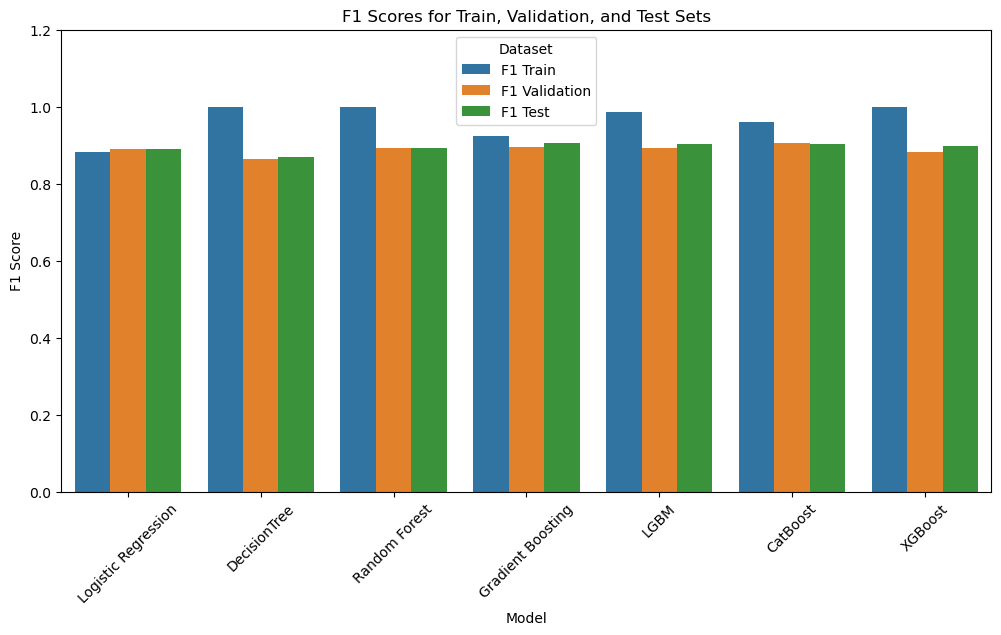

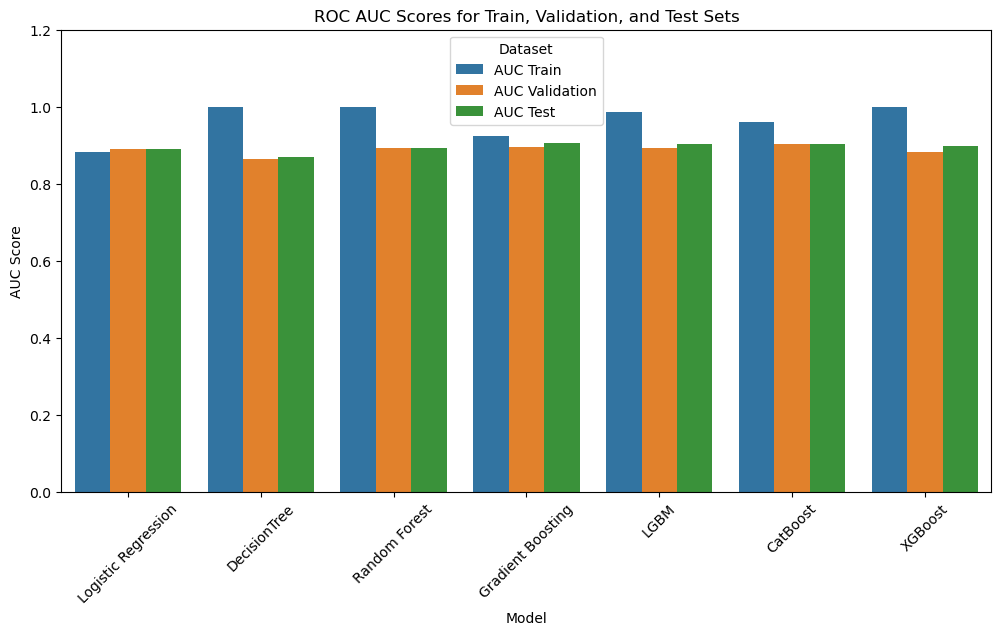

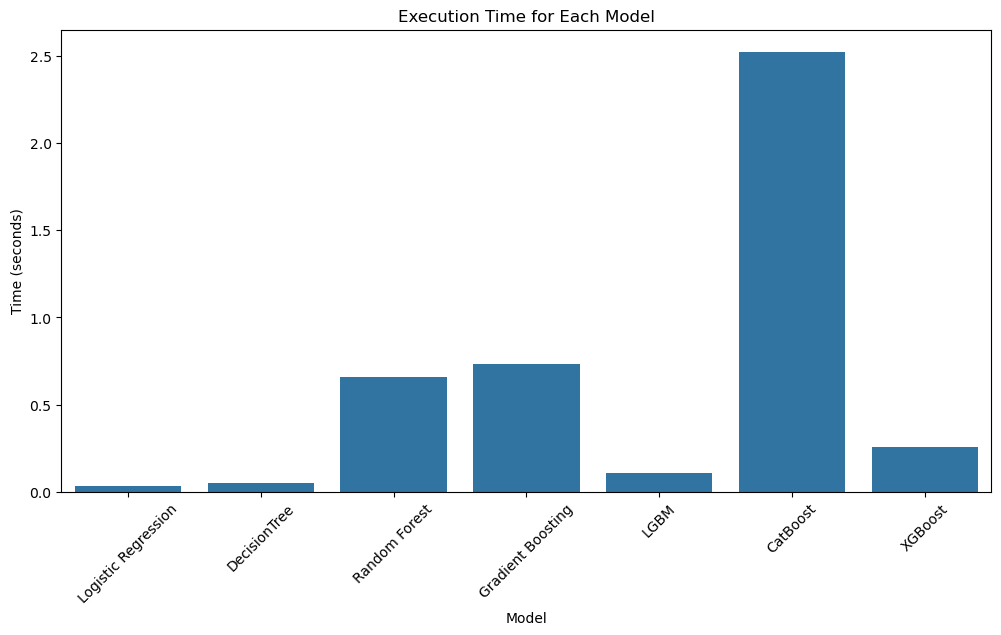

Resultados de F1 de los Modelos:
                 Model  F1 Train  F1 Validation   F1 Test
3    Gradient Boosting  0.923016       0.895254  0.906854
4                 LGBM  0.986399       0.893733  0.903016
5             CatBoost  0.958942       0.904505  0.903012
6              XGBoost  0.999230       0.882144  0.898409
2        Random Forest  1.000000       0.892173  0.893788
0  Logistic Regression  0.881359       0.890472  0.889949
1         DecisionTree  1.000000       0.865257  0.868357
Resultados de AUC de los Modelos:
                 Model  AUC Train  AUC Validation  AUC Test
3    Gradient Boosting   0.923005        0.894724  0.906757
4                 LGBM   0.986383        0.893312  0.903043
5             CatBoost   0.958935        0.904044  0.902987
6              XGBoost   0.999228        0.881516  0.898585
2        Random Forest   1.000000        0.891639  0.893904
0  Logistic Regression   0.881360        0.889313  0.890580
1         DecisionTree   1.000000        0.864876

In [24]:
plot_and_print_scores(models, model_names, f1_scores, roc_auc_scores, time_scores)

<div class="alert alert-block alert-info">
<b>

# Conclusiones 

* Gradient Boosting, CatBoost y LGBM son las mejores opciones en términos de rendimiento (F1 Score y AUC). Si el tiempo de entrenamiento no es una limitación, estos modelos son recomendables.
* XGBoost y Random Forest pueden ser considerados si se ajustan adecuadamente para evitar el sobreajuste.
* Logistic Regression y DecisionTree pueden ser útiles para obtener resultados rápidos y como modelos base, pero no son los más efectivos para este problema específico.

</b> <a class="tocSkip"></a>

## Optimización de parámetros (Grid Search)

https://scikit-learn.org/1.5/modules/grid_search.html

- Es una técnica de optimización de hiperparámetros utilizada en el aprendizaje automático para encontrar la mejor combinación de hiperparámetros para un modelo. 
- Funciona probando exhaustivamente todas las combinaciones posibles de un conjunto predefinido de hiperparámetros y evaluando el rendimiento del modelo para cada combinación.
Características principales:

1. Definir el Espacio de Búsqueda: Se especifica un conjunto de hiperparámetros y sus posibles valores. Por ejemplo, para un modelo de árbol de decisión, los hiperparámetros pueden incluir la profundidad máxima del árbol (max_depth) y el número mínimo de muestras requeridas para dividir un nodo (min_samples_split).
2. Entrenamiento y Evaluación: Para cada combinación de hiperparámetros en el espacio de búsqueda, se entrena el modelo y se evalúa su rendimiento utilizando una métrica de evaluación (por ejemplo, precisión, F1 score, AUC).
3. Seleccionar la Mejor Combinación: La combinación de hiperparámetros que produce el mejor rendimiento en la métrica de evaluación se selecciona como la mejor.



In [25]:
parameters

[('Logistic Regression',
  {'C': 1.0,
   'class_weight': None,
   'dual': False,
   'fit_intercept': True,
   'intercept_scaling': 1,
   'l1_ratio': None,
   'max_iter': 100,
   'multi_class': 'deprecated',
   'n_jobs': None,
   'penalty': 'l2',
   'random_state': 12345,
   'solver': 'lbfgs',
   'tol': 0.0001,
   'verbose': 0,
   'warm_start': False}),
 ('DecisionTree',
  {'ccp_alpha': 0.0,
   'class_weight': None,
   'criterion': 'gini',
   'max_depth': None,
   'max_features': None,
   'max_leaf_nodes': None,
   'min_impurity_decrease': 0.0,
   'min_samples_leaf': 1,
   'min_samples_split': 2,
   'min_weight_fraction_leaf': 0.0,
   'monotonic_cst': None,
   'random_state': 12345,
   'splitter': 'best'}),
 ('Random Forest',
  {'bootstrap': True,
   'ccp_alpha': 0.0,
   'class_weight': None,
   'criterion': 'gini',
   'max_depth': None,
   'max_features': 'sqrt',
   'max_leaf_nodes': None,
   'max_samples': None,
   'min_impurity_decrease': 0.0,
   'min_samples_leaf': 1,
   'min_sample

In [ ]:
# grid search para los modelos utilizados

param_grid = {
    "Logistic Regression": {
        "C": [0.1, 1, 10, 100],
        "penalty": ["l1", "l2"],
        "solver": ["liblinear", "saga"],
    },
    "DecisionTree": {
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
    },
    "Random Forest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [5, 7, 9],
        "min_samples_split": [2, 4, 6],
    },
    "Gradient Boosting": {
        "n_estimators": [10, 50],
        "max_depth": [3, 5],
        "min_samples_split": [2, 4, 6],
        "min_samples_leaf": [1, 2],
    },
    "LGBM": {
        "n_estimators": [50, 60],
        "max_depth": [3, 5],
        "learning_rate": [0.1, 0.2],
    },
    "CatBoost": {
        "iterations": [50, 100],
        "depth": [3, 5],
        "learning_rate": [0.05, 0.1],
    },
    "XGBoost": {
        "n_estimators": [50, 100],
        "max_depth": [3, 5],
        "learning_rate": [0.1, 0.2],
    },
}

best_models_gs = {}

for model, params in param_grid.items():
    print(f"\n{model}")
    model_index = model_names.index(model)
    grid_search = GridSearchCV(
        models[model_index], params, scoring="roc_auc", n_jobs=-1, cv=5
    )
    grid_search.fit(train_features, train_target)
    best_models_gs[model] = grid_search.best_estimator_

    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best score: {grid_search.best_score_}")  # 8m 5s


Logistic Regression


/home/isadoji/Software/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/isadoji/Software/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/isadoji/Software/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/isadoji/Software/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/isadoji/Software/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/isad

Best parameters: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best score: 0.9567206091962757

DecisionTree
Best parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best score: 0.9132887624128154

Random Forest
Best parameters: {'max_depth': 9, 'min_samples_split': 6, 'n_estimators': 100}
Best score: 0.9606677602752358

Gradient Boosting
Best parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 50}
Best score: 0.9600976588566196

LGBM
[LightGBM] [Info] Number of positive: 1553, number of negative: 1564
[LightGBM] [Info] Number of positive: 1554, number of negative: 1564
[LightGBM] [Info] Total Bins 1411
[LightGBM] [Info] Number of data points in the train set: 3117, number of used features: 10
[LightGBM] [Info] Total Bins 1414
[LightGBM] [Info] Number of positive: 1554, number of negative: 1564
[LightGBM] [Info] Number of positive: 1553, number of negative: 1564
[LightGBM] [Info] Number of positive: 1554, number of n

In [27]:
# Definir los modelos con best_params
models_gs = [
    LogisticRegression(**best_models_gs["Logistic Regression"].get_params()),
    DecisionTreeClassifier(**best_models_gs["DecisionTree"].get_params()),
    RandomForestClassifier(**best_models_gs["Random Forest"].get_params()),
    GradientBoostingClassifier(**best_models_gs["Gradient Boosting"].get_params()),
    lgb.LGBMClassifier(**best_models_gs["LGBM"].get_params()),
    CatBoostClassifier(**best_models_gs["CatBoost"].get_params()),
    xgb.XGBClassifier(**best_models_gs["XGBoost"].get_params()),
]

# Llamar a la función

f1_scores_gs, roc_auc_scores_gs, time_scores_gs, parameters_gs = (
    train_and_evaluate_models(
        train_features,
        train_target,
        val_features,
        val_target,
        test_features,
        test_target,
        models_gs,
        model_names,
    )
)

KeyError: 'Logistic Regression'

In [ ]:
plot_and_print_scores(
    models_gs, model_names, f1_scores_gs, roc_auc_scores_gs, time_scores_gs
)

<div class="alert alert-block alert-info">
<b>

# Conclusiones 
* XGBoost es la mejor opción en términos de rendimiento (F1 Score y AUC) y tiene un tiempo de ejecución razonable. Es altamente recomendable para este problema.
* LGBM y Gradient Boosting también son excelentes opciones debido a su buen rendimiento y tiempos de ejecución moderados.
* CatBoost y Random Forest pueden ser considerados si se ajustan adecuadamente y si el tiempo de entrenamiento no es una limitación.
* Logistic Regression y DecisionTree pueden ser útiles para obtener resultados rápidos y como modelos base, pero no son los más efectivos para este problema específico.

</b> <a class="tocSkip"></a>

## Ensamble de Modelos

https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.BaggingClassifier.html

Bagging Ciassifier es un método de ensamblado (ensemble) que se utiliza en el aprendizaje automático para mejorar la precisión y la robustez de los modelos. "Bagging" es una abreviatura de "Bootstrap Aggregating". Aquí hay una explicación paso a paso de cómo funciona:

Bootstrap Sampling: Se generan múltiples subconjuntos de datos de entrenamiento a partir del conjunto de datos original mediante muestreo con reemplazo. Esto significa que algunos ejemplos pueden aparecer varias veces en un subconjunto, mientras que otros pueden no aparecer en absoluto.

Entrenamiento de Modelos: Se entrena un modelo base (por ejemplo, un árbol de decisión) en cada uno de estos subconjuntos de datos. Cada modelo base es independiente de los demás.

Agregación: Para hacer una predicción, se combinan las predicciones de todos los modelos base. En el caso de problemas de clasificación, esto generalmente se hace mediante votación mayoritaria. En problemas de regresión, se toma el promedio de las predicciones.

El BaggingClassifier puede mejorar la precisión del modelo y reducir la varianza, lo que lo hace menos propenso a sobreajustarse a los datos de entrenamiento.

In [ ]:
models_bg = [
    BaggingClassifier(estimator=DecisionTreeClassifier(), random_state=12345),
    BaggingClassifier(estimator=RandomForestClassifier(), random_state=12345),
    BaggingClassifier(estimator=GradientBoostingClassifier(), random_state=12345),
    BaggingClassifier(estimator=lgb.LGBMClassifier(), random_state=12345),
    BaggingClassifier(estimator=CatBoostClassifier(verbose=0), random_state=12345),
    BaggingClassifier(estimator=xgb.XGBClassifier(), random_state=12345),
]

model_names_bg = [
    "Bagging Decision Tree",
    "Bagging Random Forest",
    "Bagging Gradient Boosting",
    "Bagging LGBM",
    "Bagging CatBoost",
    "Bagging XGBoost",
]

# Llamar a la función

f1_scores_bg, roc_auc_scores_bg, time_scores_bg, parameters_bg = (
    train_and_evaluate_models(
        train_features,
        train_target,
        val_features,
        val_target,
        test_features,
        test_target,
        models_bg,
        model_names_bg,
    )
)

In [ ]:
plot_and_print_scores(
    models_bg, model_names_bg, f1_scores_bg, roc_auc_scores_bg, time_scores
)

<div class="alert alert-block alert-info">
<b>

* Bagging LGBM y Bagging CatBoost son las mejores opciones en términos de rendimiento (F1 Score y AUC) y son altamente recomendables para este problema.
*   Bagging XGBoost también es una excelente opción debido a su buen rendimiento y tiempo de ejecución razonable.
* Bagging Random Forest y Bagging Gradient Boosting pueden ser considerados si se ajustan adecuadamente y si el tiempo de entrenamiento no es una limitación.
* Bagging Decision Tree puede ser útil para obtener resultados rápidos y como modelo base, pero no es el más efectivo para este problema específico.

</b> <a class="tocSkip"></a>
